In [6]:
from cnn.model import build_net

from spleen_dataset.dataloader import SpleenDataloader, SpleenDataset, get_training_augmentation, get_validation_augmentation
from spleen_dataset.config import dataset_folder
from spleen_dataset.utils import get_split_deterministic, get_list_of_patients

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import random
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], False)
  except RuntimeError as e:
    print(e)

In [7]:
patients = get_list_of_patients(dataset_folder)

In [8]:
patch_size = (128, 128)
batch_size = 32
num_classes = 2
train_augmentation = get_training_augmentation(patch_size)
val_augmentation = get_validation_augmentation(patch_size)

net_list = [
    'downscaling_vgg_3', 
    'downscaling_vgg_3',
    'downscaling_vgg_3',
    'downscaling_vgg_3',
    'downscaling_vgg_3',
    'downscaling_vgg_3',
    'downscaling_vgg_3',
    'downscaling_vgg_3',
    'downscaling_vgg_3'
]

fn_dict = {
    'downscaling_vgg_3': {'cell': 'DownscalingCell', 'block': 'VGGBlock', 'kernel': 3, 'prob': 1/3},
    'upscaling_vgg_3':   {'cell': 'UpscalingCell',   'block': 'VGGBlock', 'kernel': 3, 'prob': 1/3},
    'nonscaling_vgg_3':  {'cell': 'NonscalingCell',  'block': 'VGGBlock', 'kernel': 3, 'prob': 1/3},
}

Epoch 1/50
26/26 [==============================] - 11s 323ms/step - loss: 0.9368 - gen_dice_coef: 0.1042 - soft_gen_dice_coef: 0.0632 - lr: 0.0010 - val_loss: 0.9279 - val_gen_dice_coef: 0.1350 - val_soft_gen_dice_coef: 0.0721 - val_lr: 0.0010
Epoch 2/50
26/26 [==============================] - 7s 247ms/step - loss: 0.8865 - gen_dice_coef: 0.3060 - soft_gen_dice_coef: 0.1135 - lr: 9.8378e-04 - val_loss: 0.8945 - val_gen_dice_coef: 0.3737 - val_soft_gen_dice_coef: 0.1055 - val_lr: 9.8378e-04
Epoch 3/50
26/26 [==============================] - 7s 248ms/step - loss: 0.8418 - gen_dice_coef: 0.4584 - soft_gen_dice_coef: 0.1582 - lr: 9.6753e-04 - val_loss: 0.8330 - val_gen_dice_coef: 0.5174 - val_soft_gen_dice_coef: 0.1670 - val_lr: 9.6753e-04
Epoch 4/50
26/26 [==============================] - 7s 251ms/step - loss: 0.7734 - gen_dice_coef: 0.5735 - soft_gen_dice_coef: 0.2266 - lr: 9.5125e-04 - val_loss: 0.7520 - val_gen_dice_coef: 0.6891 - val_soft_gen_dice_coef: 0.2480 - val_lr: 9.5125e-04

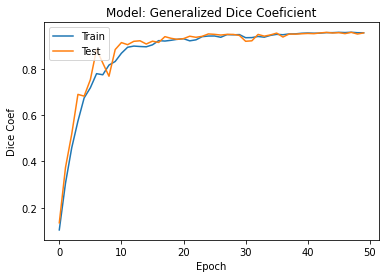

Epoch 1/50
26/26 [==============================] - 11s 302ms/step - loss: 0.9388 - gen_dice_coef: 0.1028 - soft_gen_dice_coef: 0.0612 - lr: 0.0010 - val_loss: 0.9022 - val_gen_dice_coef: 0.2141 - val_soft_gen_dice_coef: 0.0978 - val_lr: 0.0010
Epoch 2/50
26/26 [==============================] - 7s 266ms/step - loss: 0.8941 - gen_dice_coef: 0.3100 - soft_gen_dice_coef: 0.1059 - lr: 9.8378e-04 - val_loss: 0.8719 - val_gen_dice_coef: 0.3513 - val_soft_gen_dice_coef: 0.1281 - val_lr: 9.8378e-04
Epoch 3/50
26/26 [==============================] - 7s 253ms/step - loss: 0.8657 - gen_dice_coef: 0.3539 - soft_gen_dice_coef: 0.1343 - lr: 9.6753e-04 - val_loss: 0.8152 - val_gen_dice_coef: 0.4482 - val_soft_gen_dice_coef: 0.1848 - val_lr: 9.6753e-04
Epoch 4/50
26/26 [==============================] - 7s 254ms/step - loss: 0.8041 - gen_dice_coef: 0.5153 - soft_gen_dice_coef: 0.1959 - lr: 9.5125e-04 - val_loss: 0.7578 - val_gen_dice_coef: 0.4664 - val_soft_gen_dice_coef: 0.2422 - val_lr: 9.5125e-04

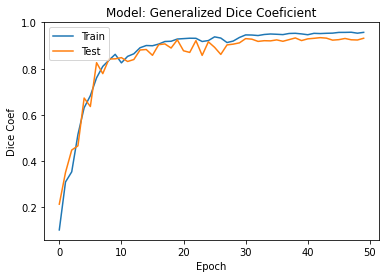

Epoch 1/50
28/28 [==============================] - 12s 316ms/step - loss: 0.9103 - gen_dice_coef: 0.1563 - soft_gen_dice_coef: 0.0897 - lr: 0.0010 - val_loss: 0.8609 - val_gen_dice_coef: 0.2957 - val_soft_gen_dice_coef: 0.1391 - val_lr: 0.0010
Epoch 2/50
28/28 [==============================] - 7s 249ms/step - loss: 0.8146 - gen_dice_coef: 0.4095 - soft_gen_dice_coef: 0.1854 - lr: 9.8378e-04 - val_loss: 0.7499 - val_gen_dice_coef: 0.6141 - val_soft_gen_dice_coef: 0.2501 - val_lr: 9.8378e-04
Epoch 3/50
28/28 [==============================] - 7s 254ms/step - loss: 0.7084 - gen_dice_coef: 0.5732 - soft_gen_dice_coef: 0.2916 - lr: 9.6753e-04 - val_loss: 0.6049 - val_gen_dice_coef: 0.8086 - val_soft_gen_dice_coef: 0.3951 - val_lr: 9.6753e-04
Epoch 4/50
28/28 [==============================] - 7s 251ms/step - loss: 0.5641 - gen_dice_coef: 0.7155 - soft_gen_dice_coef: 0.4359 - lr: 9.5125e-04 - val_loss: 0.5647 - val_gen_dice_coef: 0.6753 - val_soft_gen_dice_coef: 0.4353 - val_lr: 9.5125e-04

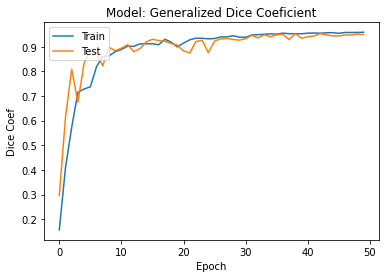

Epoch 1/50
25/25 [==============================] - 12s 342ms/step - loss: 0.9365 - gen_dice_coef: 0.0987 - soft_gen_dice_coef: 0.0635 - lr: 0.0010 - val_loss: 0.8996 - val_gen_dice_coef: 0.1859 - val_soft_gen_dice_coef: 0.1004 - val_lr: 0.0010
Epoch 2/50
25/25 [==============================] - 7s 262ms/step - loss: 0.8834 - gen_dice_coef: 0.2783 - soft_gen_dice_coef: 0.1166 - lr: 9.8378e-04 - val_loss: 0.8454 - val_gen_dice_coef: 0.3897 - val_soft_gen_dice_coef: 0.1546 - val_lr: 9.8378e-04
Epoch 3/50
25/25 [==============================] - 7s 268ms/step - loss: 0.8223 - gen_dice_coef: 0.4557 - soft_gen_dice_coef: 0.1777 - lr: 9.6753e-04 - val_loss: 0.7548 - val_gen_dice_coef: 0.5850 - val_soft_gen_dice_coef: 0.2452 - val_lr: 9.6753e-04
Epoch 4/50
25/25 [==============================] - 7s 263ms/step - loss: 0.7381 - gen_dice_coef: 0.5936 - soft_gen_dice_coef: 0.2619 - lr: 9.5125e-04 - val_loss: 0.6659 - val_gen_dice_coef: 0.6612 - val_soft_gen_dice_coef: 0.3341 - val_lr: 9.5125e-04

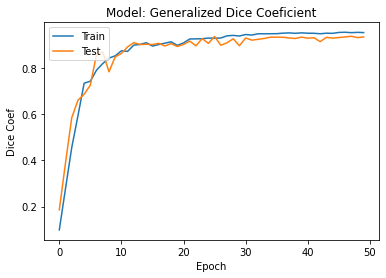

Epoch 1/50
25/25 [==============================] - 11s 324ms/step - loss: 0.9241 - gen_dice_coef: 0.1103 - soft_gen_dice_coef: 0.0759 - lr: 0.0010 - val_loss: 0.9022 - val_gen_dice_coef: 0.1415 - val_soft_gen_dice_coef: 0.0978 - val_lr: 0.0010
Epoch 2/50
25/25 [==============================] - 7s 262ms/step - loss: 0.8548 - gen_dice_coef: 0.2576 - soft_gen_dice_coef: 0.1452 - lr: 9.8378e-04 - val_loss: 0.8193 - val_gen_dice_coef: 0.3733 - val_soft_gen_dice_coef: 0.1807 - val_lr: 9.8378e-04
Epoch 3/50
25/25 [==============================] - 7s 262ms/step - loss: 0.7789 - gen_dice_coef: 0.4195 - soft_gen_dice_coef: 0.2211 - lr: 9.6753e-04 - val_loss: 0.7320 - val_gen_dice_coef: 0.5715 - val_soft_gen_dice_coef: 0.2680 - val_lr: 9.6753e-04
Epoch 4/50
25/25 [==============================] - 7s 267ms/step - loss: 0.6838 - gen_dice_coef: 0.5544 - soft_gen_dice_coef: 0.3162 - lr: 9.5125e-04 - val_loss: 0.6301 - val_gen_dice_coef: 0.6763 - val_soft_gen_dice_coef: 0.3699 - val_lr: 9.5125e-04

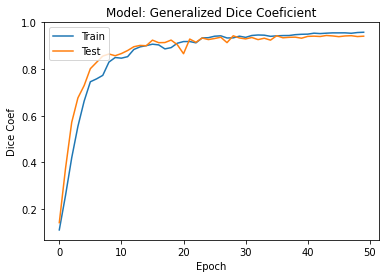

Epoch 1/50
25/25 [==============================] - 13s 380ms/step - loss: 0.9254 - gen_dice_coef: 0.1139 - soft_gen_dice_coef: 0.0746 - lr: 0.0010 - val_loss: 0.8850 - val_gen_dice_coef: 0.1994 - val_soft_gen_dice_coef: 0.1150 - val_lr: 0.0010
Epoch 2/50
25/25 [==============================] - 8s 299ms/step - loss: 0.8535 - gen_dice_coef: 0.3444 - soft_gen_dice_coef: 0.1465 - lr: 9.8378e-04 - val_loss: 0.8110 - val_gen_dice_coef: 0.4627 - val_soft_gen_dice_coef: 0.1890 - val_lr: 9.8378e-04
Epoch 3/50
25/25 [==============================] - 7s 266ms/step - loss: 0.7687 - gen_dice_coef: 0.5278 - soft_gen_dice_coef: 0.2313 - lr: 9.6753e-04 - val_loss: 0.7284 - val_gen_dice_coef: 0.4887 - val_soft_gen_dice_coef: 0.2716 - val_lr: 9.6753e-04
Epoch 4/50
25/25 [==============================] - 7s 266ms/step - loss: 0.6621 - gen_dice_coef: 0.6342 - soft_gen_dice_coef: 0.3379 - lr: 9.5125e-04 - val_loss: 0.6211 - val_gen_dice_coef: 0.6345 - val_soft_gen_dice_coef: 0.3789 - val_lr: 9.5125e-04

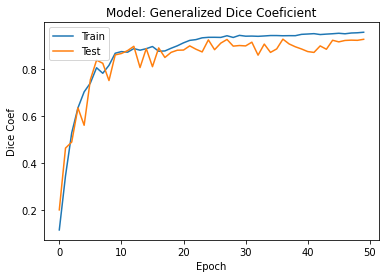

Epoch 1/50
28/28 [==============================] - 12s 318ms/step - loss: 0.9356 - gen_dice_coef: 0.1107 - soft_gen_dice_coef: 0.0644 - lr: 0.0010 - val_loss: 0.9215 - val_gen_dice_coef: 0.1650 - val_soft_gen_dice_coef: 0.0785 - val_lr: 0.0010
Epoch 2/50
28/28 [==============================] - 8s 270ms/step - loss: 0.9042 - gen_dice_coef: 0.2340 - soft_gen_dice_coef: 0.0958 - lr: 9.8378e-04 - val_loss: 0.8910 - val_gen_dice_coef: 0.2952 - val_soft_gen_dice_coef: 0.1090 - val_lr: 9.8378e-04
Epoch 3/50
28/28 [==============================] - 8s 297ms/step - loss: 0.8700 - gen_dice_coef: 0.3922 - soft_gen_dice_coef: 0.1300 - lr: 9.6753e-04 - val_loss: 0.8569 - val_gen_dice_coef: 0.4750 - val_soft_gen_dice_coef: 0.1431 - val_lr: 9.6753e-04
Epoch 4/50
28/28 [==============================] - 7s 261ms/step - loss: 0.8314 - gen_dice_coef: 0.4693 - soft_gen_dice_coef: 0.1686 - lr: 9.5125e-04 - val_loss: 0.7970 - val_gen_dice_coef: 0.5272 - val_soft_gen_dice_coef: 0.2030 - val_lr: 9.5125e-04

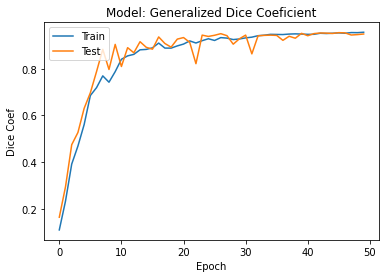

Epoch 1/50
28/28 [==============================] - 12s 319ms/step - loss: 0.9150 - gen_dice_coef: 0.1466 - soft_gen_dice_coef: 0.0850 - lr: 0.0010 - val_loss: 0.8856 - val_gen_dice_coef: 0.1980 - val_soft_gen_dice_coef: 0.1144 - val_lr: 0.0010
Epoch 2/50
28/28 [==============================] - 7s 250ms/step - loss: 0.8061 - gen_dice_coef: 0.4169 - soft_gen_dice_coef: 0.1939 - lr: 9.8378e-04 - val_loss: 0.8108 - val_gen_dice_coef: 0.3300 - val_soft_gen_dice_coef: 0.1892 - val_lr: 9.8378e-04
Epoch 3/50
28/28 [==============================] - 7s 250ms/step - loss: 0.6908 - gen_dice_coef: 0.5872 - soft_gen_dice_coef: 0.3092 - lr: 9.6753e-04 - val_loss: 0.6565 - val_gen_dice_coef: 0.6120 - val_soft_gen_dice_coef: 0.3435 - val_lr: 9.6753e-04
Epoch 4/50
28/28 [==============================] - 7s 258ms/step - loss: 0.5341 - gen_dice_coef: 0.7269 - soft_gen_dice_coef: 0.4659 - lr: 9.5125e-04 - val_loss: 0.5289 - val_gen_dice_coef: 0.6812 - val_soft_gen_dice_coef: 0.4711 - val_lr: 9.5125e-04

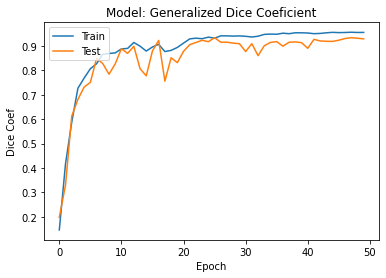

Epoch 1/50
25/25 [==============================] - 12s 377ms/step - loss: 0.9342 - gen_dice_coef: 0.1007 - soft_gen_dice_coef: 0.0658 - lr: 0.0010 - val_loss: 0.8866 - val_gen_dice_coef: 0.1900 - val_soft_gen_dice_coef: 0.1134 - val_lr: 0.0010
Epoch 2/50
25/25 [==============================] - 7s 268ms/step - loss: 0.8823 - gen_dice_coef: 0.2382 - soft_gen_dice_coef: 0.1177 - lr: 9.8378e-04 - val_loss: 0.8123 - val_gen_dice_coef: 0.4303 - val_soft_gen_dice_coef: 0.1877 - val_lr: 9.8378e-04
Epoch 3/50
25/25 [==============================] - 7s 281ms/step - loss: 0.8193 - gen_dice_coef: 0.4276 - soft_gen_dice_coef: 0.1807 - lr: 9.6753e-04 - val_loss: 0.8161 - val_gen_dice_coef: 0.3584 - val_soft_gen_dice_coef: 0.1839 - val_lr: 9.6753e-04
Epoch 4/50
25/25 [==============================] - 7s 269ms/step - loss: 0.7358 - gen_dice_coef: 0.5180 - soft_gen_dice_coef: 0.2642 - lr: 9.5125e-04 - val_loss: 0.6114 - val_gen_dice_coef: 0.7108 - val_soft_gen_dice_coef: 0.3886 - val_lr: 9.5125e-04

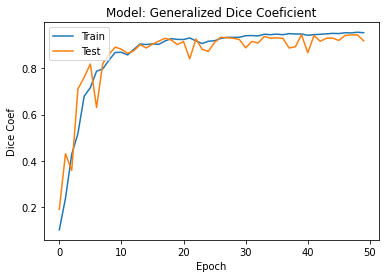

Epoch 1/50
24/24 [==============================] - 12s 363ms/step - loss: 0.9190 - gen_dice_coef: 0.1302 - soft_gen_dice_coef: 0.0810 - lr: 0.0010 - val_loss: 0.8894 - val_gen_dice_coef: 0.2099 - val_soft_gen_dice_coef: 0.1106 - val_lr: 0.0010
Epoch 2/50
24/24 [==============================] - 6s 260ms/step - loss: 0.8150 - gen_dice_coef: 0.3883 - soft_gen_dice_coef: 0.1850 - lr: 9.8378e-04 - val_loss: 0.7909 - val_gen_dice_coef: 0.4857 - val_soft_gen_dice_coef: 0.2091 - val_lr: 9.8378e-04
Epoch 3/50
24/24 [==============================] - 6s 262ms/step - loss: 0.7547 - gen_dice_coef: 0.4586 - soft_gen_dice_coef: 0.2453 - lr: 9.6753e-04 - val_loss: 0.6838 - val_gen_dice_coef: 0.6753 - val_soft_gen_dice_coef: 0.3162 - val_lr: 9.6753e-04
Epoch 4/50
24/24 [==============================] - 7s 269ms/step - loss: 0.6191 - gen_dice_coef: 0.6650 - soft_gen_dice_coef: 0.3809 - lr: 9.5125e-04 - val_loss: 0.6070 - val_gen_dice_coef: 0.6528 - val_soft_gen_dice_coef: 0.3930 - val_lr: 9.5125e-04

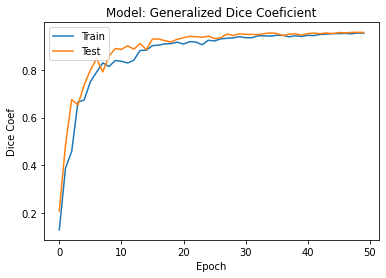

Epoch 1/50
25/25 [==============================] - 11s 339ms/step - loss: 0.9195 - gen_dice_coef: 0.1221 - soft_gen_dice_coef: 0.0805 - lr: 0.0010 - val_loss: 0.8674 - val_gen_dice_coef: 0.2481 - val_soft_gen_dice_coef: 0.1326 - val_lr: 0.0010
Epoch 2/50
25/25 [==============================] - 6s 256ms/step - loss: 0.8158 - gen_dice_coef: 0.3637 - soft_gen_dice_coef: 0.1842 - lr: 9.8378e-04 - val_loss: 0.7651 - val_gen_dice_coef: 0.5506 - val_soft_gen_dice_coef: 0.2349 - val_lr: 9.8378e-04
Epoch 3/50
25/25 [==============================] - 7s 258ms/step - loss: 0.7069 - gen_dice_coef: 0.5609 - soft_gen_dice_coef: 0.2931 - lr: 9.6753e-04 - val_loss: 0.6452 - val_gen_dice_coef: 0.6159 - val_soft_gen_dice_coef: 0.3548 - val_lr: 9.6753e-04
Epoch 4/50
25/25 [==============================] - 7s 264ms/step - loss: 0.6115 - gen_dice_coef: 0.6142 - soft_gen_dice_coef: 0.3885 - lr: 9.5125e-04 - val_loss: 0.5960 - val_gen_dice_coef: 0.5545 - val_soft_gen_dice_coef: 0.4040 - val_lr: 9.5125e-04

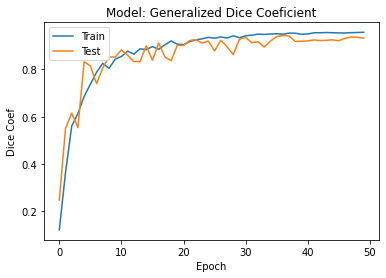

Epoch 1/50
26/26 [==============================] - 11s 327ms/step - loss: 0.9254 - gen_dice_coef: 0.1161 - soft_gen_dice_coef: 0.0746 - lr: 0.0010 - val_loss: 0.8438 - val_gen_dice_coef: 0.2718 - val_soft_gen_dice_coef: 0.1562 - val_lr: 0.0010
Epoch 2/50
26/26 [==============================] - 7s 258ms/step - loss: 0.8395 - gen_dice_coef: 0.3393 - soft_gen_dice_coef: 0.1605 - lr: 9.8378e-04 - val_loss: 0.7400 - val_gen_dice_coef: 0.5345 - val_soft_gen_dice_coef: 0.2600 - val_lr: 9.8378e-04
Epoch 3/50
26/26 [==============================] - 8s 293ms/step - loss: 0.7194 - gen_dice_coef: 0.5866 - soft_gen_dice_coef: 0.2806 - lr: 9.6753e-04 - val_loss: 0.7336 - val_gen_dice_coef: 0.5654 - val_soft_gen_dice_coef: 0.2664 - val_lr: 9.6753e-04
Epoch 4/50
26/26 [==============================] - 7s 262ms/step - loss: 0.6050 - gen_dice_coef: 0.6585 - soft_gen_dice_coef: 0.3950 - lr: 9.5125e-04 - val_loss: 0.4117 - val_gen_dice_coef: 0.8346 - val_soft_gen_dice_coef: 0.5883 - val_lr: 9.5125e-04

KeyboardInterrupt: 

In [9]:
val_gen_dice_coef_list = []
num_splits = 5
num_initializations = 3
epochs = 50
evaluation_epochs = int(0.2 * epochs)

for initialization in range(num_initializations):

    for fold in range(num_splits):
        train_patients, val_patients = get_split_deterministic(patients, fold=fold, num_splits=num_splits, random_state=initialization)

        train_dataset = SpleenDataset(train_patients, only_non_empty_slices=True)
        val_dataset = SpleenDataset(val_patients, only_non_empty_slices=True)

        train_dataloader = SpleenDataloader(train_dataset, batch_size, train_augmentation)
        val_dataloader = SpleenDataloader(val_dataset, batch_size, val_augmentation)

        model = build_net((*patch_size, 1), num_classes, fn_dict, net_list)

        def learning_rate_fn(epoch):
            initial_learning_rate = 1e-3
            end_learning_rate = 1e-4
            power = 0.9
            return ((initial_learning_rate - end_learning_rate) *
                (1 - epoch / float(epochs)) ** (power)
                ) + end_learning_rate
            
        lr_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_fn, verbose=True)

        history = model.fit(
            train_dataloader,
            validation_data=val_dataloader,
            epochs=epochs,
            verbose=1,
            callbacks=[
                lr_callback
            ]
        )
        
        print(history.history['val_gen_dice_coef'][-evaluation_epochs:])

        val_gen_dice_coef_list.extend(history.history['val_gen_dice_coef'][-evaluation_epochs:])

        # for patient in val_patients:
        #     patient_dataset = SpleenDataset([patient], only_non_empty_slices=True)
        #     patient_dataloader = SpleenDataloader(patient_dataset, 1, val_augmentation, shuffle=False)
        #     results = model.evaluate(patient_dataloader)
        #     val_gen_dice_coef_patient = results[-1]
        #     val_gen_dice_coef_list.append(val_gen_dice_coef_patient)

        #plotting the dice coef results (accuracy) as a function of the number of epochs
        plt.figure()
        plt.plot(history.history['gen_dice_coef'])
        plt.plot(history.history['val_gen_dice_coef'])
        plt.title('Model: Generalized Dice Coeficient')
        plt.ylabel('Dice Coef')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        #plotting the dice coef results (loss function) as a function of the number of epochs
        # plt.figure()
        # plt.plot(history.history['loss'])
        # plt.plot(history.history['val_loss'])
        # plt.title('Model: Generalized Dice Coeficient')
        # plt.ylabel('Dice Loss')
        # plt.xlabel('Epoch')
        # plt.legend(['Train', 'Test'], loc='upper right')
        # plt.show()

mean_val_gen_dice_coef = (np.mean(val_gen_dice_coef_list))
std_val_gen_dice_coef = (np.std(val_gen_dice_coef_list))

print(f'Dice {mean_val_gen_dice_coef} +- {std_val_gen_dice_coef}')

In [ ]:
#!tensorboard --logdir='./logs'